# About
Single-step univariate Bidirectional Long-Short term memory (Bi-LSTM)

# Libraries

In [1]:
%run "/home/cesar/Python_NBs/HDL_Project/HDL_Project/global_fv.ipynb"

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Data
from sklearn.model_selection import train_test_split

# DL Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

# Optimizer
from tensorflow.keras.optimizers import Adam

# Plotting
import matplotlib.pyplot as plt

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping

# Checkpoint
from keras.callbacks import ModelCheckpoint

# Global parameters

# User-Defined Functions

In [3]:
def design_model(n_steps, lr, n_features = 1):
    """
    n_steps: Number of steps
    n_features: Number of features
    lr: Learning rate
    """
    # We can define a 1D CNN Model for univariate time series forecasting as follows:
    model = Sequential(name = "Bidirectional-LSTM-model")
    
    # Number of neurons (nodes) are just about greater than the number of features.
    # Rule of thumb is for number of neurons to be about 2/3 of the input    
    num_neurons = 128 
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(num_neurons, activation= 'relu' ), input_shape=(n_steps, n_features)))
    
    # Output layer with one neuron to a model instance (to return one output)
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # Regularization prevents the learning process to completely fit the model to the training data which can lead to overfitting.
    # The most common regularization method is dropout.
    #model.add(layers.Dropout(0.1))    
    
    # Optimizer
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt,  metrics=['mae'], loss= 'mse')
    
    return model


In [4]:
def fit_model_es_checkpoint(X, y, learning_rate, num_epochs, bs, model):
    checkpoint_name = 'Trained_Models/U_Weights_BiLSTM_-{val_loss:.5f}--{epoch:03d}.hdf5'
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
    checkpoint_callback = ModelCheckpoint(checkpoint_name, monitor='mae', verbose=0, save_best_only=True, mode='min')
    history = model.fit(X, y, epochs=num_epochs, batch_size=bs, validation_split = 0.30, verbose = 0, shuffle = False, callbacks=[early_stopping_callback, checkpoint_callback])
    return history

# Data

##  Parameters

In [5]:
# SQL commands to retrieve data
sql_table = "sima_pm25"
column = "NE"
sql_where = "where datetime >= \'2021-04-17\'"

# Percentage of time series dedicated for test split
test_partition = 0.3

# Number of time steps per sample
n_steps = 24

## Data Preparation

## Sample preparation

In [6]:
uni_ts = univariate_samples(sql_table, column, sql_where)
X, y = uni_ts.samples_creation(n_steps)

sql_table = "sima_station_CE"
target = "pm25"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_partition, shuffle= False)

In [7]:
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))
print()
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print()
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X shape: (63912, 24)
y shape: (63912,)

X_train shape: (44738, 24)
y_train shape: (44738,)

X_test shape: (19174, 24)
y_test shape: (19174,)


# Model

In [8]:
learning_rate = 0.01
model = design_model(n_steps, learning_rate)

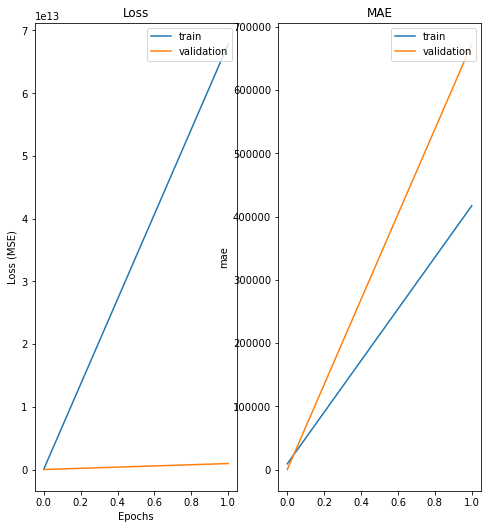

Min training Loss: 68238753792.0
Min validation Loss:  560076.5625

Final training MAE: nan
Final validation MAE: nan


In [9]:
#Training with early stopping

# Maximum number of epochs
num_epochs = 300

#fixed learning rate value
learning_rate = 0.01

#fixed number of batches
batch_size = 4

history = fit_model_es_checkpoint(X, y, learning_rate, num_epochs, batch_size, model)
          
#plotting
plt.figure(figsize=(8,5))
plt.subplots_adjust(bottom=0.1, top=1.4)
plt.tight_layout()

# plot learning curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend(loc="upper right")


# plot learning curves
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='validation')
plt.title("MAE")
plt.ylabel('mae')
plt.legend(loc="upper right")

plt.show()

plt.cla()
plt.clf()
plt.close('all')

print("Min training Loss:", min(history.history["loss"]))
print("Min validation Loss: ", min(history.history["val_loss"]))
print("")
print("Final training MAE:", history.history['mae'][-1])
print("Final validation MAE:", history.history['val_mae'][-1])

# Validation